<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>TensorFlow Probability </font></h3>

* 状態空間モデルの構築はTensorFlow Probabilityが一番リファレンスが整っており、実装しやすいと思い、個人的な学習ノートを作成することにしました。
* 以下ではTensorFlow Probabilityで時系列分析を行うコードを紹介します。
* コードは公開されている以下のオンラインブックから引用しています。
* Martin Osvaldo A, Kumar Ravin; Lao Junpeng Bayesian Modeling and Computation in Python Boca Ratón, 2021. ISBN 978-0-367-89436-8
* https://bayesiancomputationbook.com/welcome.html

In [1]:
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
root = tfd.JointDistributionCoroutine.Root

import datetime
print(f"Last Run {datetime.datetime.now()}")

Last Run 2023-11-08 20:19:24.758165


In [2]:
az.style.use("arviz-grayscale")
plt.rcParams["figure.dpi"] = 300

In [3]:
co2_by_month = pd.read_csv("monthly_mauna_loa_co2.csv")
co2_by_month["date_month"] = pd.to_datetime(co2_by_month["date_month"])
co2_by_month["CO2"] = co2_by_month["CO2"].astype(np.float32)
co2_by_month.set_index("date_month", drop=True, inplace=True)

num_forecast_steps = 12 * 10 #過去のデータが与えられたときの直近10年の予測
co2_by_month_training_data = co2_by_month[:-num_forecast_steps]
co2_by_month_testing_data = co2_by_month[-num_forecast_steps:]


C:\Users\satyk\AppData\Local\Temp\ipykernel_14744\3764899787.py:19: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.autofmt_xdate()


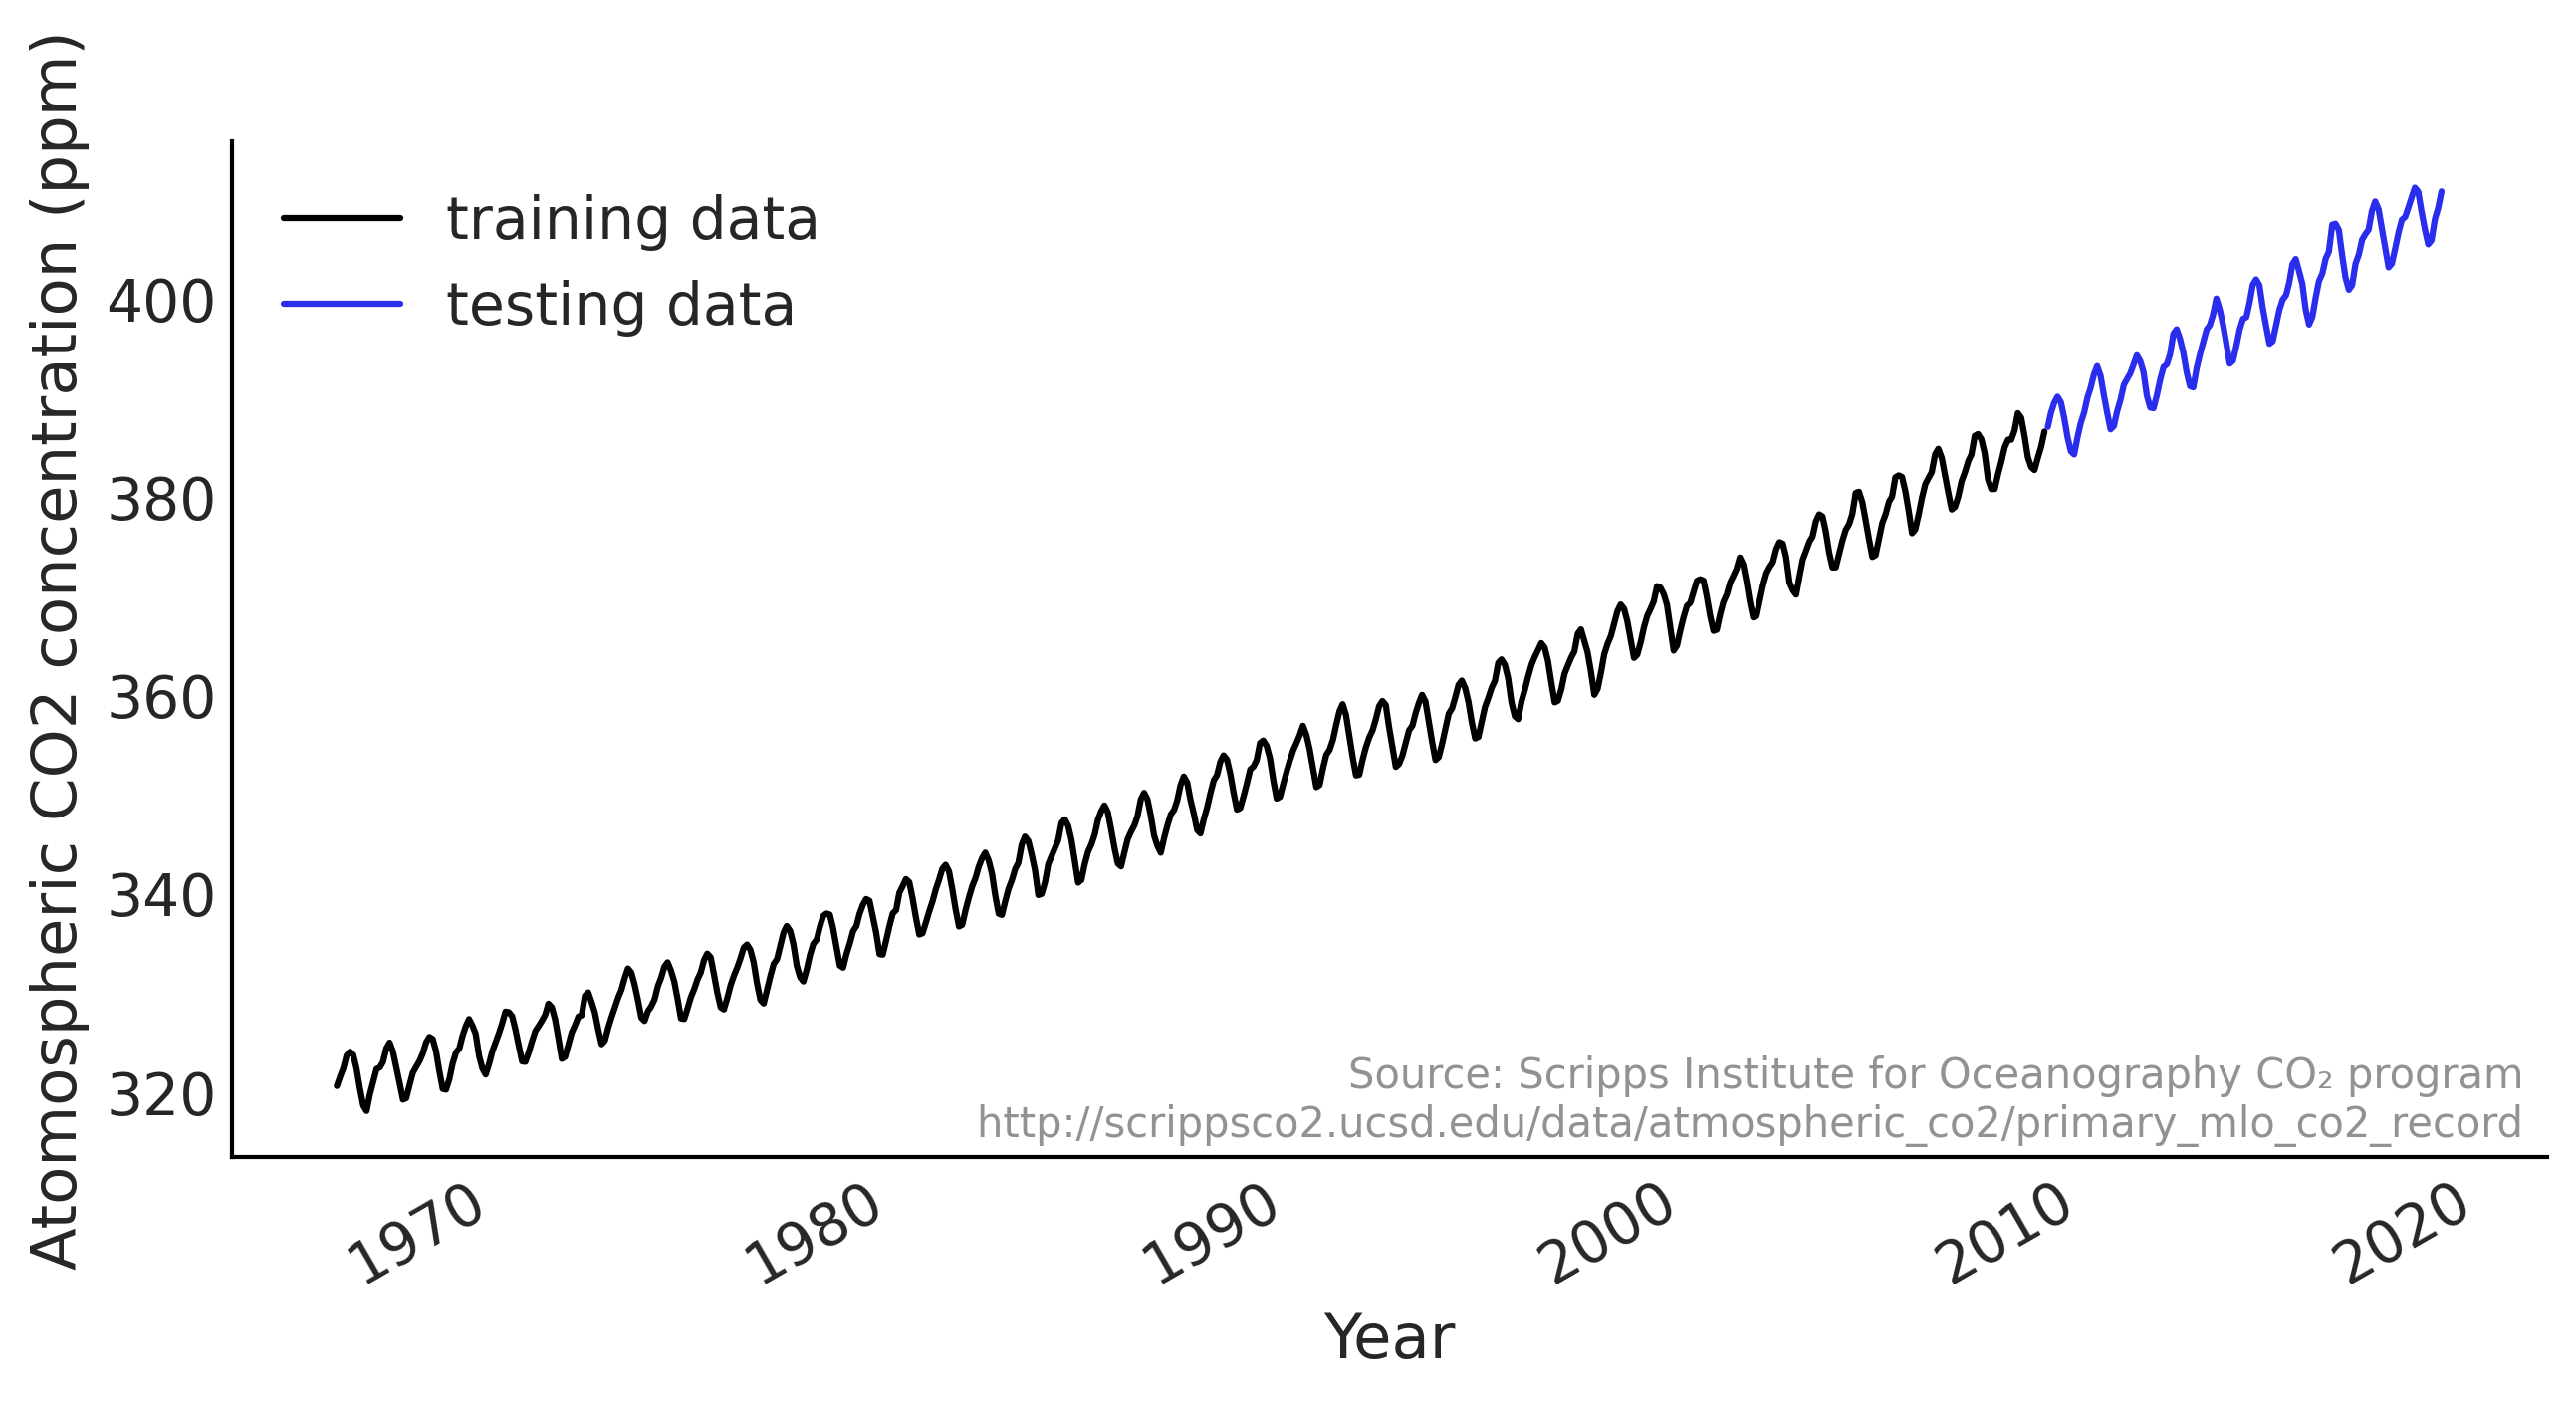

In [14]:
def plot_co2_data(fig_ax=None):
    if not fig_ax:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    else:
        fig, ax = fig_ax
    ax.plot(co2_by_month_training_data, label="training data")
    ax.plot(co2_by_month_testing_data, color="C4", label="testing data")
    ax.legend()
    ax.set(
       ylabel="Atomospheric CO2 concentration (ppm)",
       xlabel="Year"
    )
    ax.text(0.99, .02,
            """Source: Scripps Institute for Oceanography CO₂ program
            http://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record""",
            transform=ax.transAxes,
            horizontalalignment="right",
            alpha=0.5)
    fig.autofmt_xdate()
    return fig, ax


_ = plot_co2_data()


    

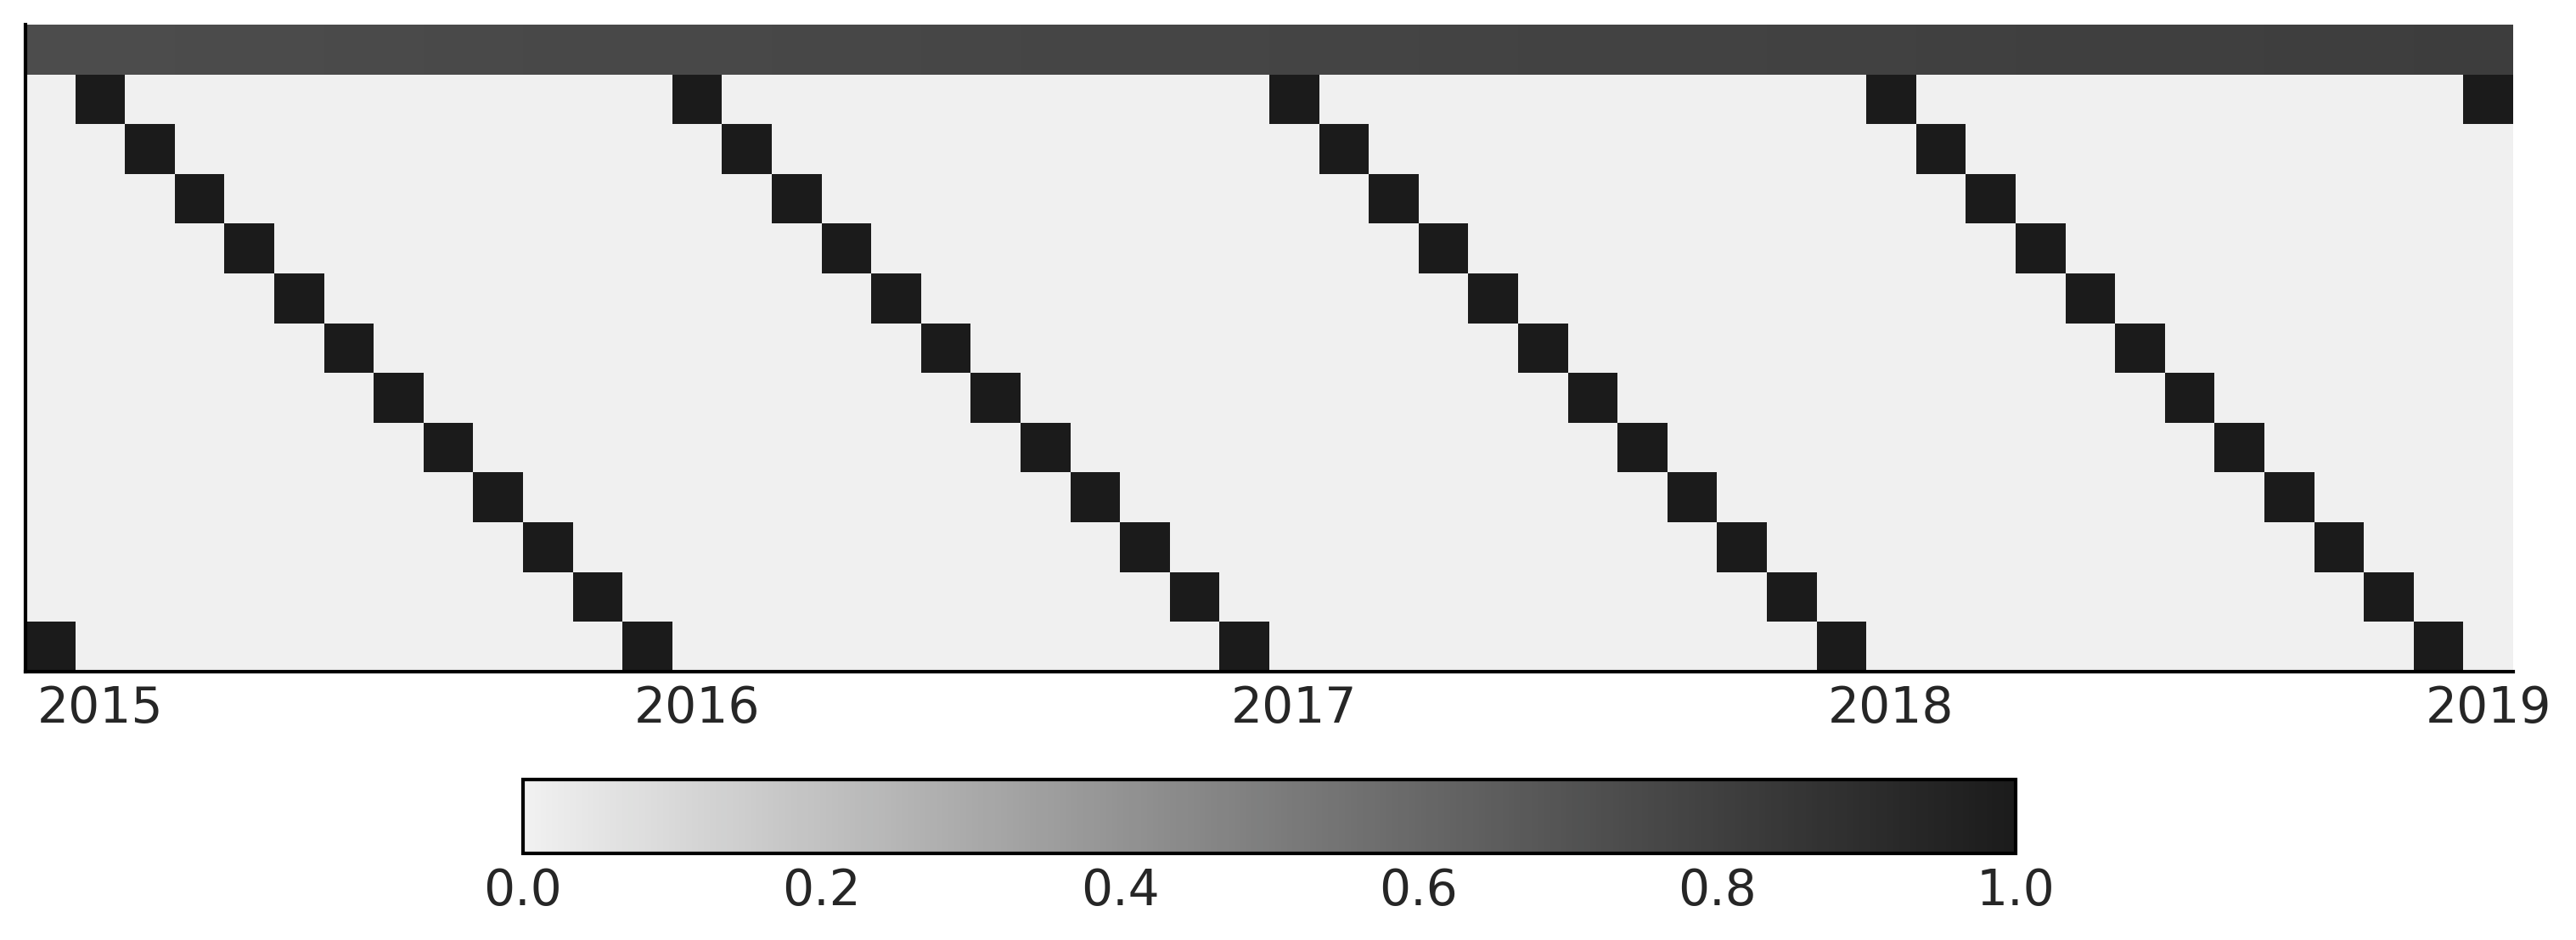

In [4]:
trend_all = np.linspace(0., 1., len(co2_by_month))[..., None]
trend_all = trend_all.astype(np.float32)
trend = trend_all[:-num_forecast_steps, :]

seasonality_all = pd.get_dummies(
    co2_by_month.index.month).values.astype(np.float32)
seasonality = seasonality_all[:-num_forecast_steps, :]

fig, ax = plt.subplots(figsize=(10, 4))
X_subset = np.concatenate([trend, seasonality], axis=-1)[-50:]
im = ax.imshow(X_subset.T, cmap="cet_gray_r")

label_loc = np.arange(1, 50, 12)
ax.set_xticks(label_loc)
ax.set_yticks([])
ax.set_xticklabels(co2_by_month.index.year[-50:][label_loc])
fig.colorbar(im, ax=ax, orientation="horizontal", shrink=.6)

In [5]:
tfd = tfp.distributions
root = tfd.JointDistributionCoroutine.Root

@tfd.JointDistributionCoroutine
def ts_regression_model():
    intercept = yield root(tfd.Normal(0., 100., name="intercept"))
    trend_coeff = yield root(tfd.Normal(0., 10., name="trend_coeff"))
    seasonality_coeff = yield root(
        tfd.Sample(tfd.Normal(0., 1.),
                   sample_shape=seasonality.shape[-1],
                   name="seasonality_coeff"))
    noise = yield root(tfd.HalfCauchy(loc=0., scale=5., name="noise_sigma"))
    y_hat = (intercept[...,None] +
             tf.einsum("ij,...->...i", trend, trend_coeff) +
             tf.einsum("ij,...j->...i", seasonality, seasonality_coeff))
    observed = yield tfd.Independent(
        tfd.Normal(y_hat, noise[..., None]),
        reinterpreted_batch_ndims=1,
        name="observed")


C:\Users\satyk\AppData\Local\Temp\ipykernel_14744\1447978575.py:9: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.autofmt_xdate()


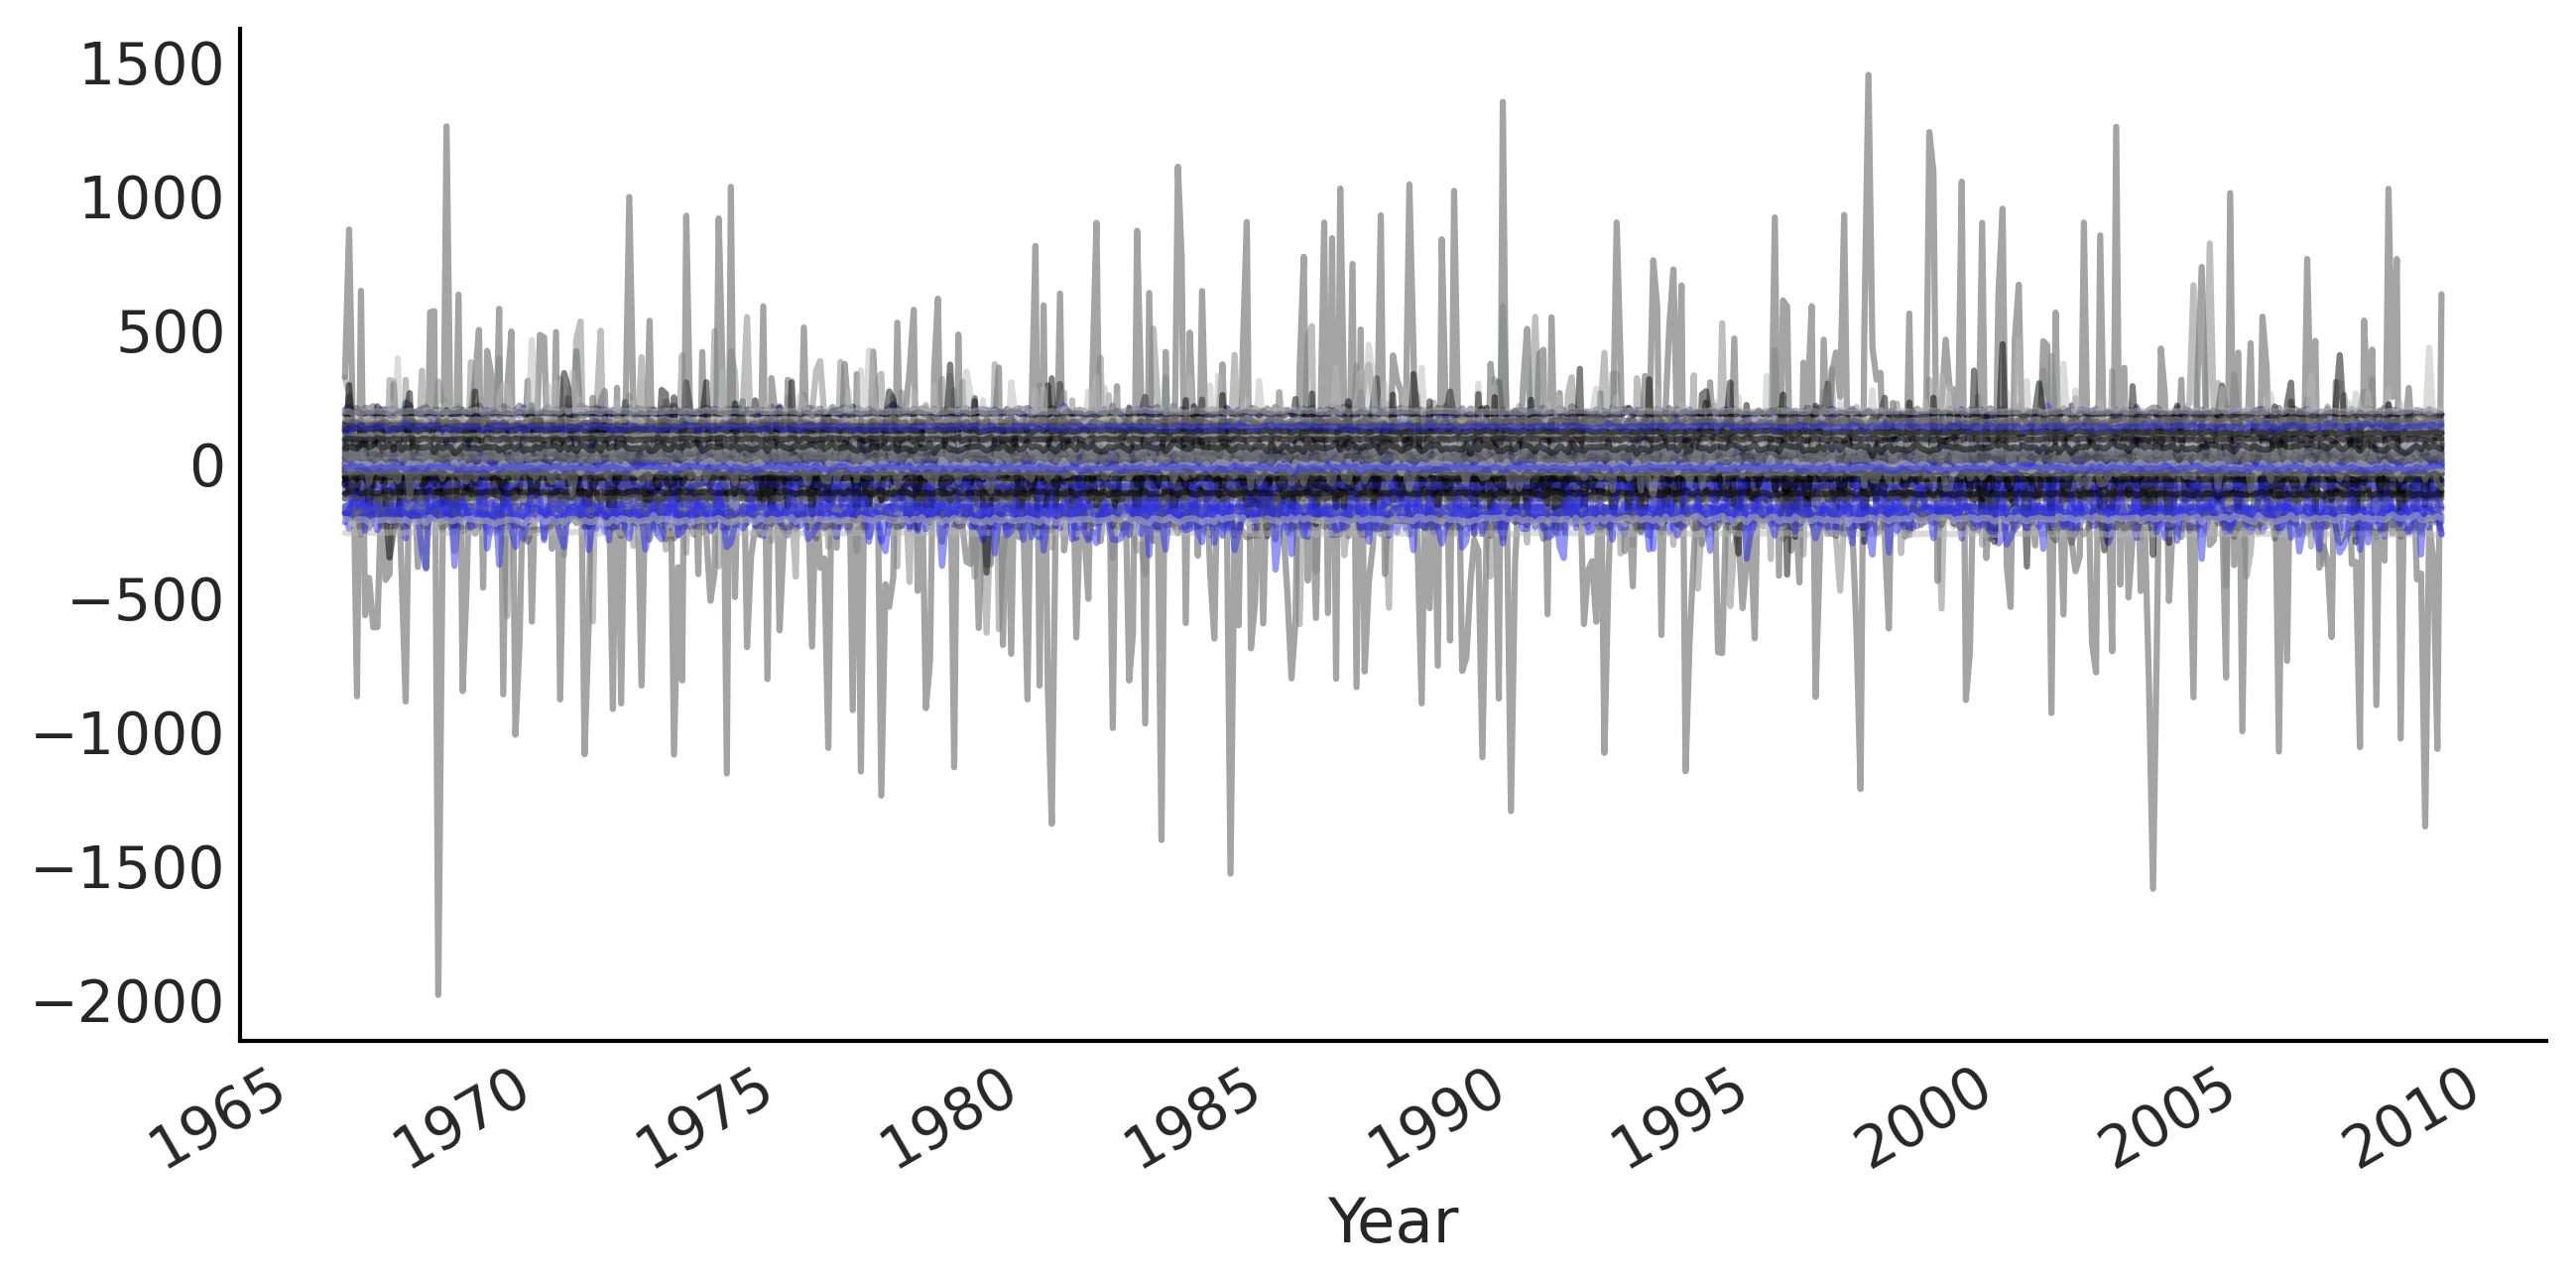

In [6]:
# 100個の事前分布と事前予測のサンプルをドローする
prior_samples = ts_regression_model.sample(100)
prior_predictive_timeseries = prior_samples.observed

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(co2_by_month.index[:-num_forecast_steps],
        tf.transpose(prior_predictive_timeseries),alpha=.5)
ax.set_xlabel("Year")
fig.autofmt_xdate()

In [7]:
run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts,
    autograph=False, jit_compile=True)
mcmc_samples, sampler_stats = run_mcmc(
    1000, ts_regression_model, n_chains=4, num_adaptation_steps=1000,
    observed=co2_by_month_training_data["CO2"].values[None,...])

regression_idata = az.from_dict(
    posterior={
        # TFPのmcmcは、(num_samples, num_chains, ...)を返す。
        # ここでArvizが期待するデータの形に整えるために、
        # それぞれのRVについて初めの軸と二本目の軸を交換する。
        k:np.swapaxes(v.numpy(), 1, 0)
        for k, v in mcmc_samples._asdict().items()},
    sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]})

In [8]:
#jd.sample_distributions()を使用して事後予測サンプルを描画できます。
#ただし、トレーニングデータとテストデータの両方に条件付けられた
#各成分の事後予測分布もプロットしたいため、以下のように事後予測分布を構築します。
nchains = regression_idata.posterior.dims["chain"]

trend_posterior = mcmc_samples.intercept + \
   tf.einsum("ij,...->i...", trend_all, mcmc_samples.trend_coeff)
seasonality_posterior = tf.einsum(
    "ij,...j->i...", seasonality_all, mcmc_samples.seasonality_coeff)

y_hat = trend_posterior + seasonality_posterior
posterior_predictive_dist = tfd.Normal(y_hat, mcmc_samples.noise_sigma)
posterior_predictive_samples = posterior_predictive_dist.sample()

C:\Users\satyk\AppData\Local\Temp\ipykernel_14744\405488223.py:13: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.autofmt_xdate()


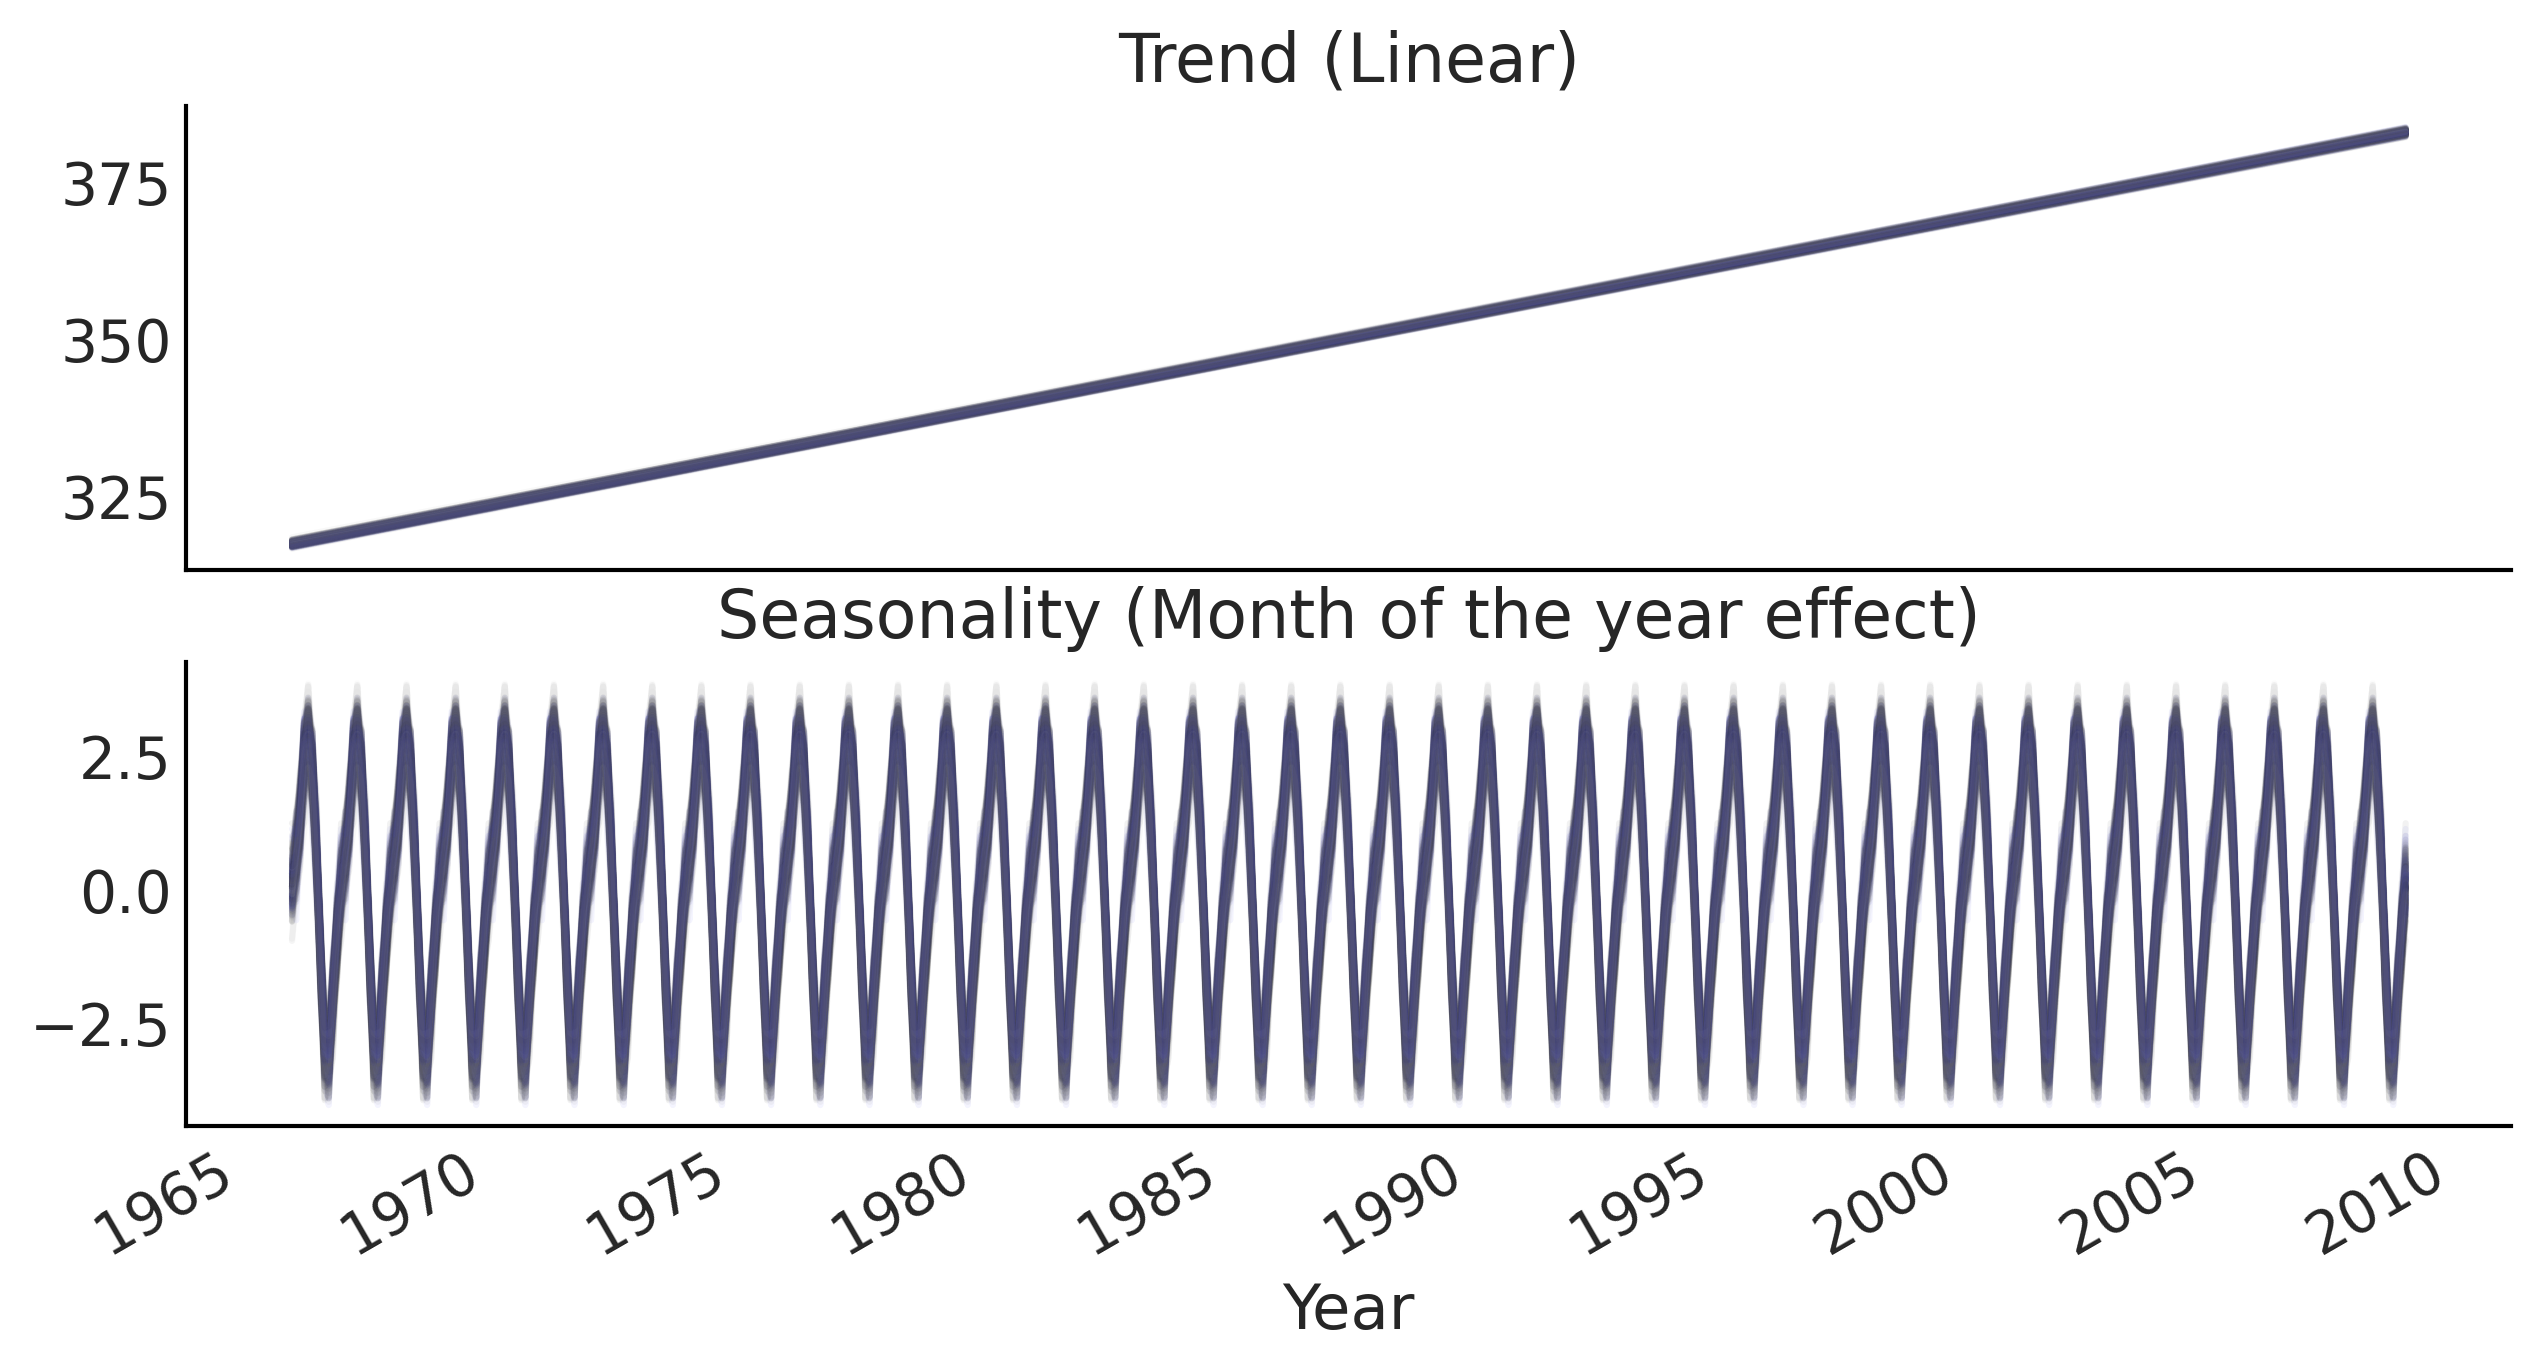

In [9]:
#plot components
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

for i in range(nchains):
    ax[0].plot(co2_by_month.index[:-num_forecast_steps],
               trend_posterior[:-num_forecast_steps,-100:, i], alpha=.05)
    ax[1].plot(co2_by_month.index[:-num_forecast_steps],
            seasonality_posterior[:-num_forecast_steps, -100:, i],alpha=.05)

ax[0].set_title('Trend (Linear)')
ax[1].set_title('Seasonality (Month of the year effect)')
ax[1].set_xlabel("Year")
fig.autofmt_xdate()

C:\Users\satyk\AppData\Local\Temp\ipykernel_14744\3764899787.py:19: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.autofmt_xdate()


(<Figure size 3000x1500 with 1 Axes>,
 <AxesSubplot:xlabel='Year', ylabel='Atomospheric CO2 concentration (ppm)'>)

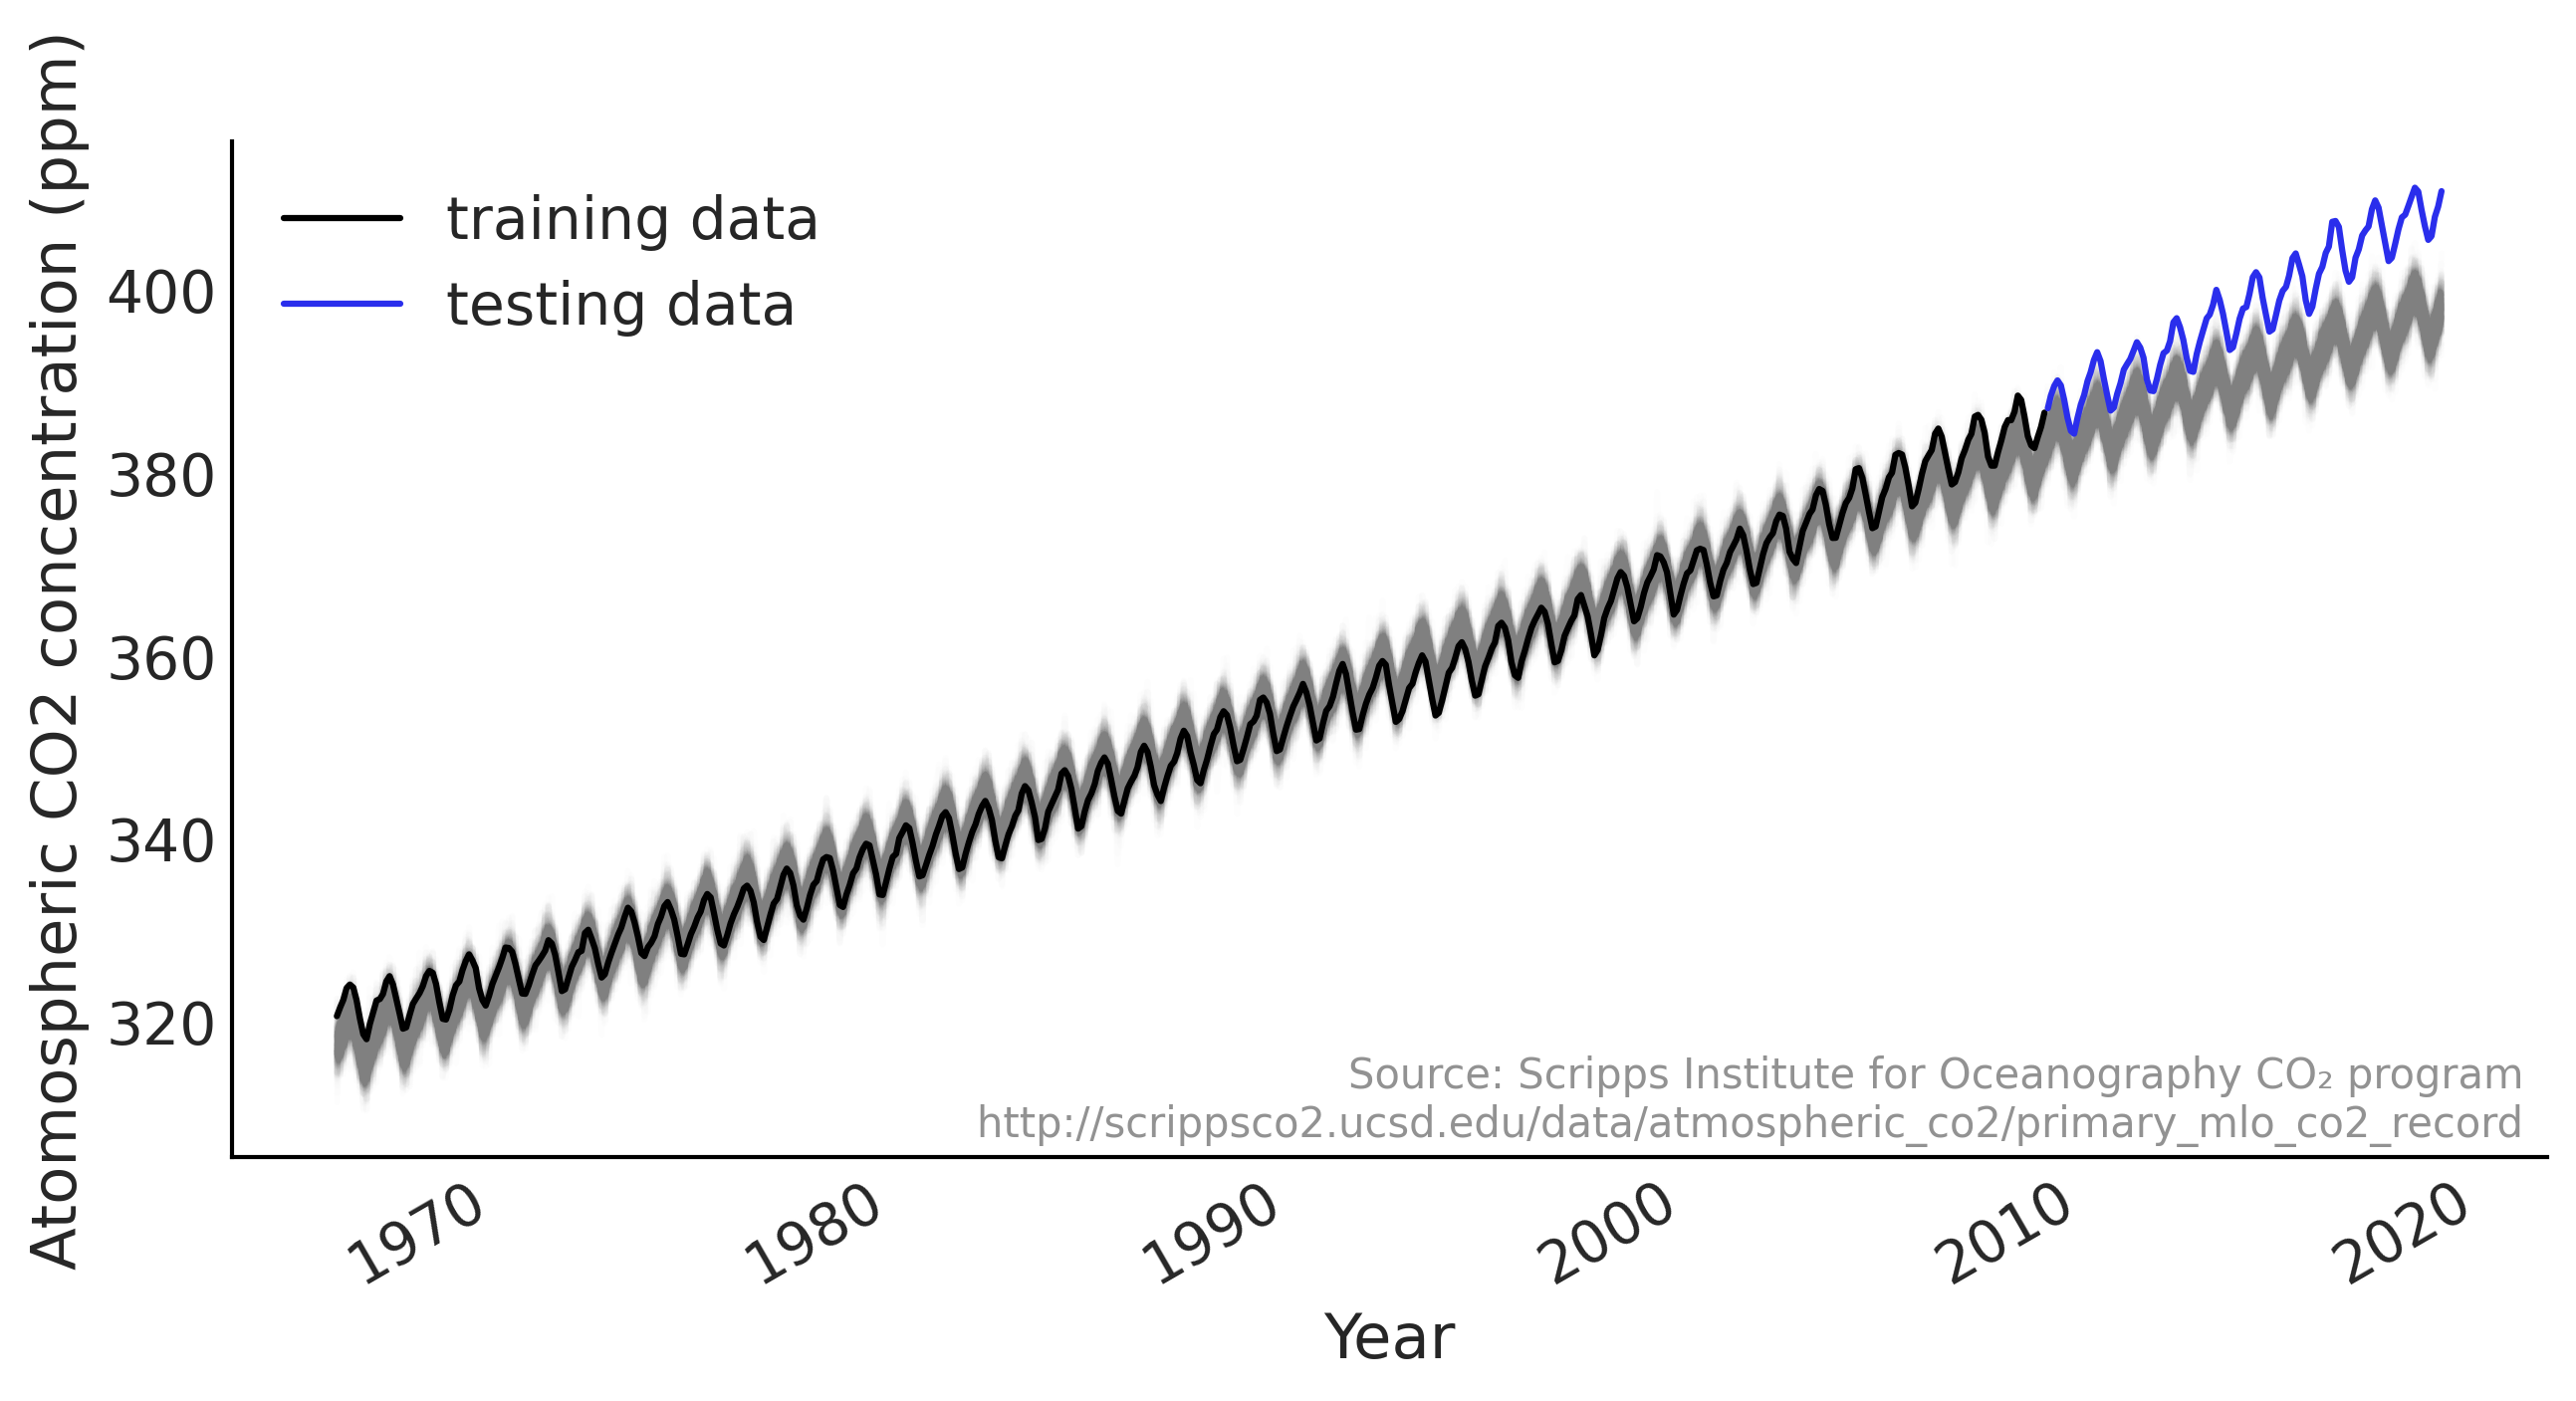

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sample_shape = posterior_predictive_samples.shape[1:]
ax.plot(co2_by_month.index,
        tf.reshape(posterior_predictive_samples,
                   [-1, tf.math.reduce_prod(sample_shape)])[:,:500],
        color='gray', alpha=.01)

plot_co2_data((fig, ax))